# Анализ продаж компьютерных игр.

<a id='section_1'></a>
## Исходные данные для анализа.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('/datasets/games.csv')
display(df)
print('----------------------')
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] * 100 / df.shape[0]).round(2)
display(report.sort_values(by = 'missing_values', ascending = False))
print('----------------------')
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


----------------------


,missing_values,% of total
Critic_Score,8578,51.32
Rating,6766,40.48
User_Score,6701,40.09
Year_of_Release,269,1.61
Name,2,0.01
Genre,2,0.01
Platform,0,0.00
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00


----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод.

На данном этапе имеется большое кол-во пропущенных значений в столбцах с оценками критиков и пользователей, а также рейтингом ESRB. Пропуски в оценках могут быть связаны с тем, что источники, с которых они были получены не содержали всех игр, включённых в анализ. Также оценки могут отсутствовать для игр, выпущенных непосредственно перед сбором данных. Присвоение рейтинга ESRB началось только в 1994 году, поэтому для всех игр, выпущенных ранее, значение может отсутствовать. А для игр, выпущенных недавно, рейтинг ESRB может быть ещё не сформирован. Также не указан год для 269 игр, название и жанр - для двух. Эти пропуски могут быть связаны с ошибками при сборе данных. Нулевые значения в столбцах продаж по регионам могут означать, что игра не продавалась в данном регионе. Тип данных в столбцах года выпуска и пользовательской оценки некорректен.

<a id='section_2.1'></a>
## Подготовка данных.

В начале приведём назавания столбцов к нижнему регистру:

In [3]:
df.columns = df.columns.str.lower()

Создадим столбец с суммарными продажами для каждой игры:

In [4]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Название игры.

Как показал изначальный анализ, в столбце пристутствуют пропущенные значения.

In [5]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


Данные строки имеют полезную для последующего анализа информацию (название платформы, год, продажи по регионам). Название игры в данном случае не так важно, как и жанр (игры слишком давно выпущены), поэтому оставим эти строки в таблице.

### Название платформы.

Виды платформ, представленных в таблице:

In [6]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Глядя на это разнообразие, отдельно хочется сказать "спасибо" компании Nintendo. Но, в целом, придраться не к чему. В этом можно убедиться с помощью https://www.vgchartz.com/analysis/platform_totals/.

### Год выпуска.

Выведем на экран строки с пропущенными значениями.

In [7]:
missed_years = df[df['year_of_release'].isna()]
missed_years

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+,0.01
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,0.01
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


Распределение пропусков по платформам.

In [8]:
missed_years['platform'].value_counts()

PS2     34
Wii     34
X360    30
DS      30
PS3     25
XB      21
2600    17
PC      17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
PSV      1
GB       1
Name: platform, dtype: int64

В целом, ничего особенного. Заполнить пропуски, как мне кажется, можно несколькими способами:
- подставить вручную, что очень долго.
- использовать имеющиеся значения, в случае кроссплатформенной игры. Например:

In [9]:
df[df['name'] == 'Madden NFL 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E,1.09
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E,0.51
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E,0.31


Но, в этом случае можно допустить ошибку, т.к. выход игры на разные платформы не всегда происходит в одно время. Например:

In [10]:
df[df['name'] == 'Space Invaders']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN,0.46
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN,0.16
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN,0.11


Видимо, лучше просто удалить строки с отсутствующими данными:

In [11]:
df.dropna(subset = ['year_of_release'], inplace = True)
df['year_of_release'] = df['year_of_release'].astype('int')

### Жанр.

В таблице встречаются следующие жанры:

In [12]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Жанры указаны как нужно (каждый обозначен вполне конкретно и не пересекается с остальными). Строки с пропущенными значениями решено было оставить в пункте 2.1.

### Оценка критиков.

Согласно заданию оценки критиков должны быть расположены в пределах от 0 до 100. Проверим, имеются ли значения вне этого диапазона:

In [13]:
df[(df['critic_score'] > 100) | (df['critic_score'] < 0)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


Выведем строки с пропущенными значениями в столбце "оценка критиков":

In [14]:
missed_cs = df[df['critic_score'].isna()]
missed_cs

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


Оценки отсутствуют как у старых игр, так и у новых. Заменить их средним или медианой нельзя, т.к. значения будут некорректны. Но и удалять строки нет необходимости. Видимо, в следующий раз данные нужно собирать более тщательно.

### Оценка пользователей.

In [15]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Значений меньше 0 или больше 10 нет. Но, присутствуют игры с оценкой tbd. Данная абревиатура обозначает, что на данный момент оценка ещё не определена (не опубликована, слишком мало значений для расчёта).

In [16]:
df[df['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E,6.70
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,3.97
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T,2.81
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E,2.42
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E,2.24
...,...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E,0.01
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E,0.01
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E,0.01


Заменим значения 'tbd' на пропуски:

In [17]:
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype('float')

Также как и с оценками критиков, заменить пропущенные значения возможности нет.

###  Рейтинг ESRB.

In [18]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Изучив официальный сайт и Википедию, получим следующие выводы:
- рейтинг ЕС в 2018 упразднили, но оставим его как есть (теоретически, его можно перевести в Е, но предположим всё же, что сейчас декабрь 2016);
- рейтинг К-А с 1998 называется Е (поэтому их можно объединить);
- рейтинг RP означает отсутствие рейтинга на данный момент (переведём эти значения в NaN).

In [19]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'] = df['rating'].replace('RP', np.nan)

<a id='section_2.2'></a>
### Проверка на наличие дубликатов.

Проверим данные на наличие полных дубликатов:

In [20]:
df.duplicated().sum()

0

### Вывод.

В результате предобработки данных были удалены строки, в которых не был указан год выпуска игр. Для каждой игры были добавлены суммарные продажи. Пропущенные значения для оценок критиков и пользователей, а также рейтинга ESRB изменены не были.

## Исследовательский анализ данных.

<a id='section_3.1'></a>
### Анализ количества выпущенных игр в год.

Построим гистограмму распределения количества игр по годам:

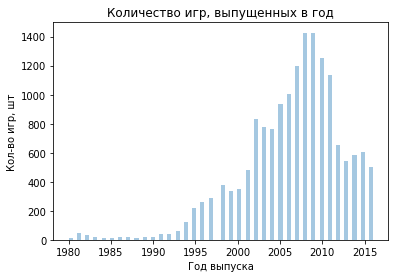

In [21]:
ax = sns.distplot(df['year_of_release'], bins=74, kde=False)
ax.set_title('Количество игр, выпущенных в год')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Кол-во игр, шт')
plt.show()

На графике видно, что после 2011 года количество выпускаемых игр резко уменьшилось. Это связано с последствиями финансового кризиса 2008 года, который не обошёл стороной и игровую индстрию. Большое количество студий закрылось, часть была поглащена более крупными, часть ушла в мобильный гейминг. Также, начали набирать популярность онлайн игры, поддержка которых осуществляется несколько лет. Начиная с 2012 года количество имеет приблизительно равное распределение. Возможно, данный период (2012 - 2016) будет наиболее актуальным для анализа.

<a id='section_3.2'></a>
### Распределение продаж по платформам.

Рассчитаем суммарные продажи для каждой платформы.

In [22]:
df.groupby(['platform'])\
    .agg({'total_sales':'sum'})\
    .sort_values(by='total_sales', ascending=False)\
    .reset_index()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Выделим 5 платформ с наибольшими продажами и построим график:

In [23]:
top_sales = (
    df.query('platform == "PS2" or platform == "X360" or platform == "PS3"\
    or platform == "Wii" or (platform == "DS" and year_of_release >= 2004)')
    .groupby(['platform', 'year_of_release'])
    .agg({'total_sales':'sum'})
    .reset_index()
)

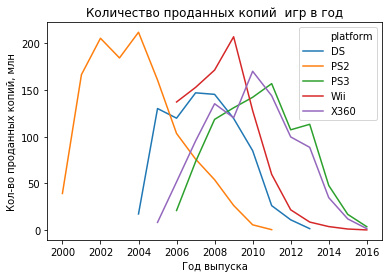

In [24]:
ax = sns.lineplot(x='year_of_release', y='total_sales', hue='platform', data=top_sales)
ax.set_title('Количество проданных копий  игр в год')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Кол-во проданных копий, млн')
plt.show()

На примере приставок от Сони видно, что в среднем игровая консоль имеет жизненный цикл около 5 лет. При этом игры выпускаются/продаются на протяжении 10 лет. Исключение составляет ПК, т.к. на поддержку новых игр влияют возможности комплектующих и версия ПО.

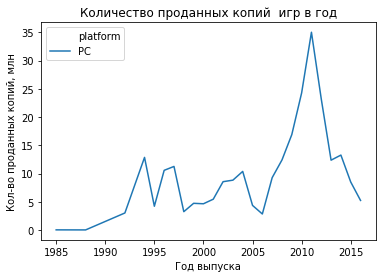

In [25]:
pc_sales = (
    df.query('platform == "PC"')
    .groupby(['platform', 'year_of_release'])
    .agg({'total_sales':'sum'})
    .reset_index()
)

ax = sns.lineplot(x='year_of_release', y='total_sales', hue='platform', data=pc_sales)
ax.set_title('Количество проданных копий  игр в год')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Кол-во проданных копий, млн')
plt.show()

<a id='section_3.3'></a>
### Определение актуального периода для анализа.

В результате, можно предположить, что для анализа подойдёт период с 2012 по 2016. Данный промежуток имеет наиболее близкие значения по количеству выпущенных игр.

In [27]:
actual_df = df.query('year_of_release >= 2012').reset_index(drop=True)

<a id='section_3.4'></a>
### Сравнение платформ.

Сравним платформы по продажам за выбранный период.

In [28]:
sales = (
    actual_df
    .groupby(['platform', 'year_of_release'])
    .agg({'total_sales':'sum'})
    .reset_index()
)

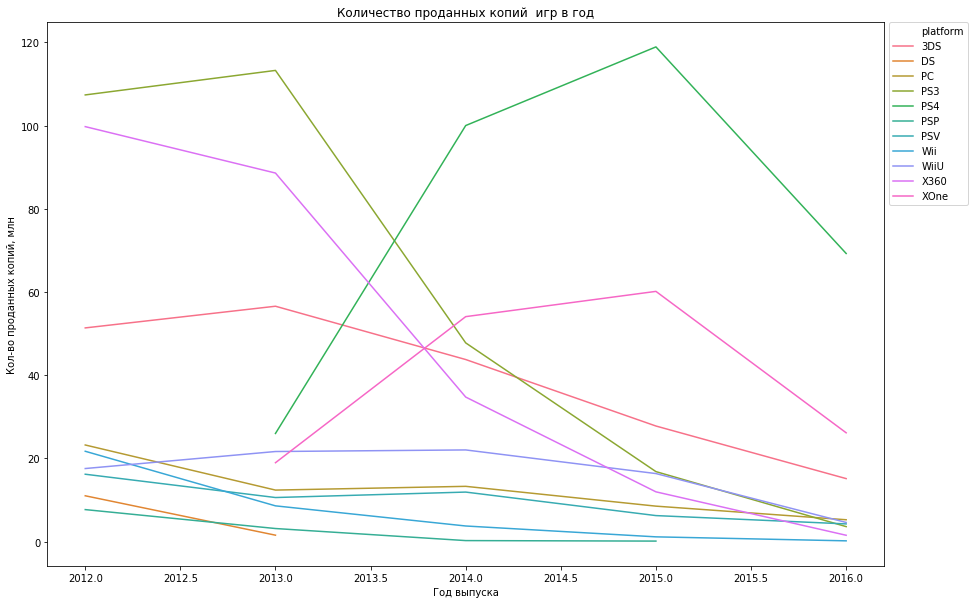

In [29]:
plt.figure(figsize=(15, 10))
ax = sns.lineplot(x='year_of_release', y='total_sales', hue='platform', data=sales)
ax.set_title('Количество проданных копий  игр в год')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Кол-во проданных копий, млн')
plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)
plt.show()

Наиболее популярными платформами являются PlayStation 4, Xbox One и Nintendo 3DS. Вслучае с Nintendo 3DS можно заметить спад, начиная с 2013 года. Падение количества продаж PlayStation 4 и Xbox One может быть связано с неполными данными за 2016 год. Также стоит отметить, что резко потеряли популярность консоли PlayStation 3 и Xbox 360 (это произошло по причине выхода консолей следующего поколения им на смену).

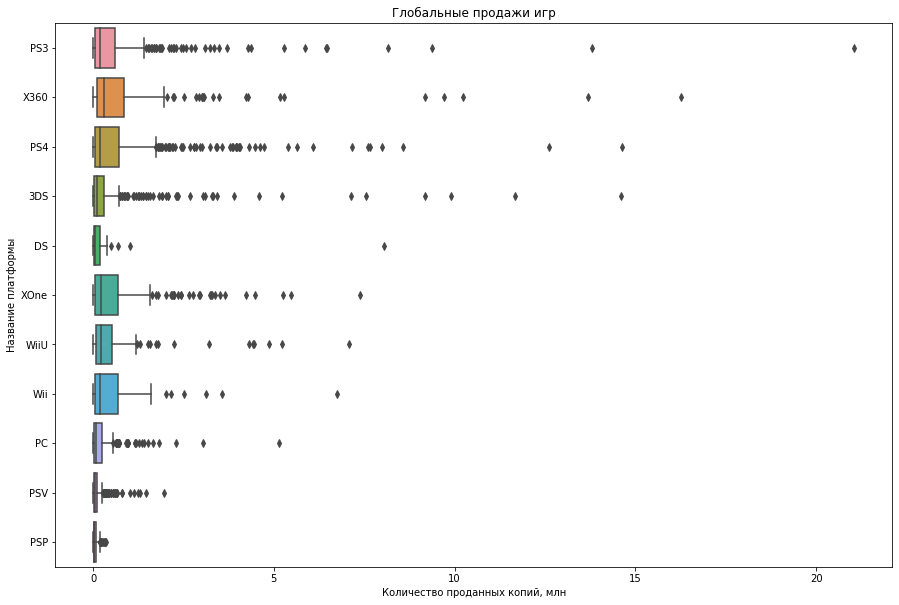

In [30]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='total_sales', y='platform', data=actual_df)
ax.set_title('Глобальные продажи игр')
ax.set_xlabel('Количество проданных копий, млн')
ax.set_ylabel('Название платформы')
plt.show()

In [31]:
actual_df.groupby('platform').agg({'total_sales':['mean', 'median']}).round(2).reset_index()

platform total_sales       
                   mean median
0       3DS        0.49   0.11
1        DS        0.40   0.05
2        PC        0.25   0.08
3       PS3        0.59   0.20
4       PS4        0.80   0.20
5       PSP        0.06   0.03
6       PSV        0.12   0.05
7       Wii        0.65   0.18
8      WiiU        0.56   0.22
9      X360        0.81   0.31
10     XOne        0.65   0.22

Данные распределения указывают на то, что на всех платформах имеется несколько крайне популярных игр, расходящихся многомиллионными тиражами. При этом медианное значение в среднем менее 0,2 млн копий.

<a id='section_3.5'></a>
### Влияние отзывов пользователей и критиков.

На примере приставки Xbox One рассмотрим влияние оценок критиков и пользователей на суммарные продажи игр.

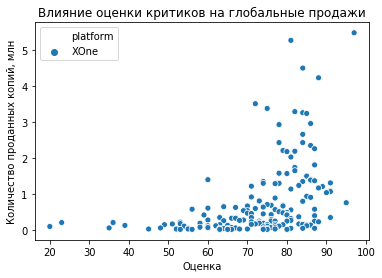

In [32]:
ax = sns.scatterplot(data=actual_df.query('platform == "XOne"'), x="critic_score", y="total_sales", hue='platform')
ax.set_title('Влияние оценки критиков на глобальные продажи')
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество проданных копий, млн')
plt.show()

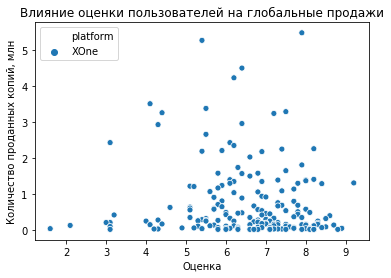

In [33]:
ax = sns.scatterplot(data=actual_df.query('platform == "XOne"'), x="user_score", y="total_sales", hue='platform')
ax.set_title('Влияние оценки пользователей на глобальные продажи')
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество проданных копий, млн')
plt.show()

In [34]:
print('Значение корреляции между оценками критиков и глобальными продажами для Xbox One:',\
      actual_df.query('platform == "XOne"')['total_sales'].corr(actual_df.query('platform == "XOne"')['critic_score']).round(2))
print('Значение корреляции между оценками пользователей и глобальными продажами для Xbox One:',\
      actual_df.query('platform == "XOne"')['total_sales'].corr(actual_df.query('platform == "XOne"')['user_score']).round(2))

Значение корреляции между оценками критиков и глобальными продажами для Xbox One: 0.42
Значение корреляции между оценками пользователей и глобальными продажами для Xbox One: -0.07


В случае с Xbox One можно предположить, что оценки пользователей не оказывают влияния на продажи. При этом оценки критиков имеют небольшую положительную связь (чем выше оценка, тем более успешно игра продаётся).

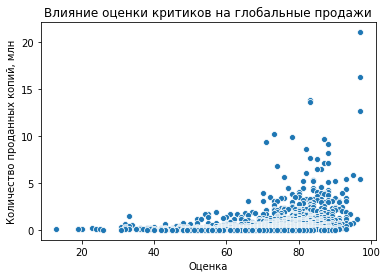

In [35]:
ax = sns.scatterplot(data=actual_df, x="critic_score", y="total_sales")
ax.set_title('Влияние оценки критиков на глобальные продажи')
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество проданных копий, млн')
plt.show()

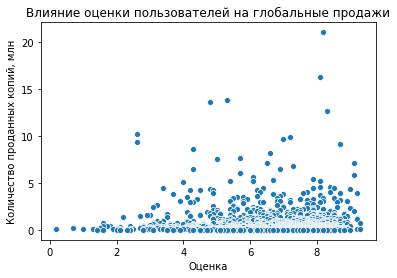

In [36]:
ax = sns.scatterplot(data=actual_df, x="user_score", y="total_sales")
ax.set_title('Влияние оценки пользователей на глобальные продажи')
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество проданных копий, млн')
plt.show()

In [37]:
print('Значение корреляции между оценками критиков и глобальными продажами:',\
      actual_df['total_sales'].corr(actual_df['critic_score']).round(2))
print('Значение корреляции между оценками пользователей и глобальными продажами:',\
      actual_df['total_sales'].corr(actual_df['user_score']).round(2))

Значение корреляции между оценками критиков и глобальными продажами: 0.31
Значение корреляции между оценками пользователей и глобальными продажами: 0.0


В случае со всеми приставками, всё выглядит аналогично Xbox One. Данную закономерность можно объяснить следующим образом: оценки критиков обычно появляются перед релизом или непосредственно в момент релиза игры (они не всегда объективны, могут являться частью рекламной кампании), поэтому высокие оценки могут повысить интерес пользователей и увеличить продажи. Пользователи, в основном, оценивают игры уже после покупки.

<a id='section_3.6'></a>
### Распределение по жанрам.

In [38]:
genre_sales = (
    actual_df
    .groupby('genre')
    .agg({'total_sales':'sum'})
    .sort_values(by='total_sales', ascending=False)
    .reset_index()
)

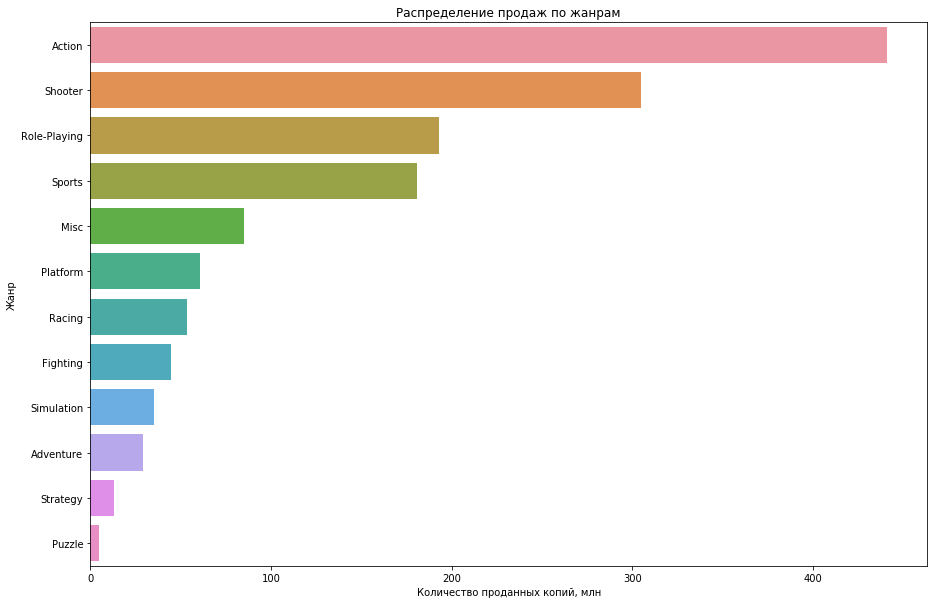

In [39]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(data=genre_sales, x='total_sales', y='genre')
ax.set_title('Распределение продаж по жанрам')
ax.set_xlabel('Количество проданных копий, млн')
ax.set_ylabel('Жанр')
plt.show()

При распредении продаж по жанрам можно сказать, что самыми популярными являются Action и Shooter. Меньше всего пользуются спросом стратегии и пазлы.

### Вывод.

При анализе выбранного периода (2012-2016) были выявлены следующие закономерности:
- наиболее популярными приставками являются PlayStation 4 и Xbox One;
- оценки пользователей не влияют на количество проданных копий;
- оценки критиков влияют на популярность игры;
- наиболее популярными жанрами являются Action и Shooter.

## Портрет пользователя каждого региона.

<a id='section_4.1'></a>
### Топ-5 платформ.

Выберем наиболее популярные платформы для пользователей каждого региона на данный момент.

In [40]:
for region in ['na', 'eu', 'jp']:
    new_df = actual_df.groupby('platform').sum()[region + '_sales'].sort_values(ascending=False).head(5)
    new_df = new_df.rename('total').to_frame()
    new_df['per'] = (new_df.total * 100 / new_df.total.sum()).round(1).astype(str) + '%'
    display(new_df)

,total,per
platform,,
X360,140.05,28.0%
PS4,108.74,21.7%
PS3,103.38,20.7%
XOne,93.12,18.6%
3DS,55.31,11.0%


,total,per
platform,,
PS4,141.09,33.9%
PS3,106.86,25.6%
X360,74.52,17.9%
XOne,51.59,12.4%
3DS,42.64,10.2%


,total,per
platform,,
3DS,87.79,50.7%
PS3,35.29,20.4%
PSV,21.04,12.2%
PS4,15.96,9.2%
WiiU,13.01,7.5%


Если рассматривать 3 наиболее популярных в мире приставки (PlayStation 4, Xbox One и Nintendo 3DS), то можно заметить, что в Северной Америке игры для приставок от Sony и Microsoft продаются приблизительно в равных количествах, тогда как в Европе PlayStation 4 сильно популярнее Xbox One. В Японии продукция Microsoft вообще не популярна, а предпочтение отдаётся портативным консолям (Nintendo 3DS).

<a id='section_4.2'></a>
### Топ-5 жанров.

In [41]:
for region in ['na', 'eu', 'jp']:
    display(actual_df.groupby('genre').sum()[region + '_sales'].sort_values(ascending=False).head(5))

genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

Популярные жанры в Северной Америке и Европе практически не отличаются. Предпочтение отдаётся играм в жанрах Action, Shooter и Sports. В Японии наиболее популярным жанром является RPG.

<a id='section_4.3'></a>
### Влияние рейтинга ESRB.

In [42]:
actual_df['rating'] = actual_df['rating'].fillna('Unrated') #учёл пропуски 

In [43]:
esrb = actual_df.groupby('rating').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum'})
esrb

,na_sales,eu_sales,jp_sales
rating,,,
E,114.37,113.03,28.33
E10+,75.70,55.37,8.19
M,231.57,193.96,21.20
T,66.02,52.96,26.02
Unrated,103.31,91.50,108.84


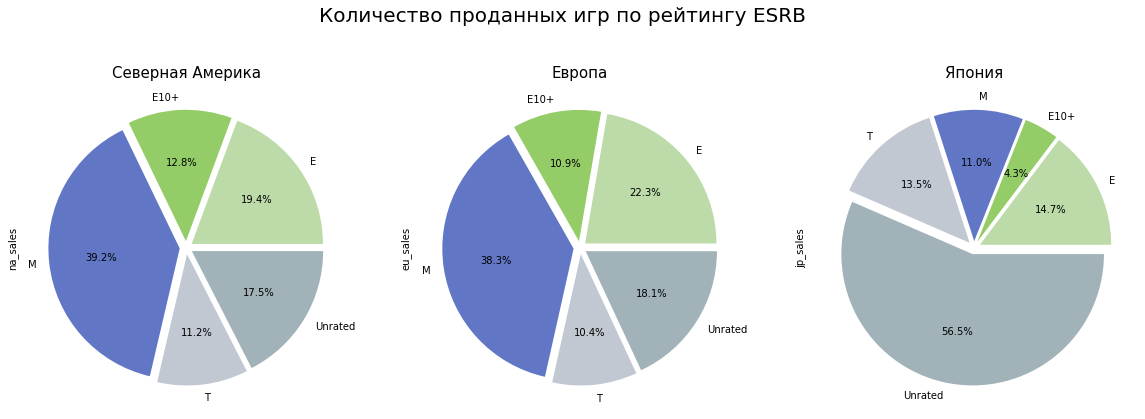

In [44]:
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
colors = ['#bcdba9', '#94cc68', '#6177c5', '#c1c8d2', '#a1b3b8']
ax = esrb.plot.pie(subplots=True, autopct='%1.1f%%', legend=False, explode=explode, colors=colors, figsize=(20, 20))
plt.subplots_adjust(top=1.5)
plt.suptitle("Количество проданных игр по рейтингу ESRB", fontsize=20)
ax[0].set_title("Северная Америка", fontsize=15)
ax[1].set_title("Европа", fontsize=15)
ax[2].set_title("Япония", fontsize=15)
plt.show()

Из графиков видно, что продажи в Северной Америке и Европе в зависимости от рейтинга похожи. В обоих регионах наибольшей популярностью пользуются игры с рейтингом M. В данных для Японии отсутствует слишком много значений. Корректного анализа сделать нельзя.

### Вывод.

В результате можно сделать следующие предположения:
- в Северной Америке популярны игры, выпускаемые для PlayStation и Xbox в жанрах Action и Shooter с рейтингами M и E;
- в Европе популярны игры, выпускаемые для Playstation в жанрах Action и Shooter с рейтингами M и E;
- в Японии популярны игры, выпускаемые для 3DS в жанрах Role-Playing и Action.

<a id='section_5'></a>
## Проверка гипотез.

Проверим гипотезу о том, что средние пользовательские рейтинги Xbox One и PC одинаковые. Предположение, что рейтинги одинаковы, примем за нулевую гипотезу. Различие рейтингов - за альтернативную. Критический уровень статистической значимости - 0,05.

In [45]:
u_score = actual_df.dropna(subset = ['user_score']).reset_index()

In [46]:
# Посчитаем дисперсию для каждой платформы:
var_xone = np.var(u_score[u_score['platform'] == 'XOne']['user_score'], ddof=1).round(2)
var_pc = np.var(u_score[u_score['platform'] == 'PC']['user_score'], ddof=1).round(2)
print(var_xone, var_pc)

1.91 2.77


In [47]:
# Т.к. значения дисперсий различаются, установим параметр equal_var=False.
alpha = 0.05
results = st.ttest_ind(u_score[u_score['platform'] == 'XOne']['user_score'],\
                       u_score[u_score['platform'] == 'PC']['user_score'],\
                       equal_var=False)
display(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5489537965134912

Не получилось отвергнуть нулевую гипотезу


Проверим гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports различаются. За нулевую гипотезу примем отсутсвие различий, за альтернативную - рейтинги различаются. Критический уровень статистической значимости - 0,05.

In [48]:
# Посчитаем дисперсию для каждого жанра:
var_xone = np.var(u_score[u_score['genre'] == 'Action']['user_score'], ddof=1).round(2)
var_pc = np.var(u_score[u_score['genre'] == 'Sports']['user_score'], ddof=1).round(2)
print(var_xone, var_pc)

1.89 3.02


In [49]:
# Т.к. значения дисперсий различаются, установим параметр equal_var=False.
alpha = 0.05
results = st.ttest_ind(u_score[u_score['genre'] == 'Action']['user_score'],\
                       u_score[u_score['genre'] == 'Sports']['user_score'],\
                       equal_var=False)
display(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.24307776572644e-20

Отвергаем нулевую гипотезу


### Вывод. 

Можно предположить, что пользовательские оценки для Xbox One и ПК одинаковые, а для жанров Action и Sports различаются.

<a id='section_6'></a>
## Общие выводы.

В результате исследования были обработаны и изучены данные по продажам игр с 80-х годов прошлого века до наших дней. На этапе подготовки данных были найдены и по возможности обработаны пропуски, заменены типы данных, а также выявлены различные особенности:
- количество выпускаемых ежегодно игр резко сократилось после 2011 года;
- наиболее успешными за весь период платформами являются PlayStation 2, Xbox 360, PlayStation 3, Nintendo Wii и Nintendo DS;
- смена поколений игровых платформ происходит в среднем каждые 5 лет, при этом поддержка осуществляется на протяжении 10 лет.

Для определения успешных в будущем платформ для анализа был выбран период с 2012 года. При исследовании данного временного промежутка удалось получить следующие выводы:
- наиболее перспективными платформами являются PlayStation 4 и Xbox One;
- наиболее популярными жанрами являются Action и Shooter;
- игры с высокими оценками критиков продаются бОльшими тиражами;
- зависимости между пользовательскими оценками и продажами игр установлено не было.

Также для каждого крупного региона (Северная Америка, Европа и Япония) были выявлены отличительные особенности:
- в Северной Америке одинаково популярны как Xbox, так и PlayStation. В Европе PlayStation является единоличным лидером. В Японии отдают предпочтение портативным консолям Nintendo 3DS.
- Популярные жанры (Action, Shooter и Sports) в Европе и Северной Америке не различаются. В Японии предпочитают игры в жанре RPG.